# Benders decomposition for Fixed Charge Network Flow

Consider the following optimisation problem:

* Given a network $(N,A)$ of nodes & potential (directed) arcs;
* Given a set of origin-destination pairs $(o_k,d_k)$ for $k\in K$ (referred to as commodities);
* Determine the set of arcs to "build" or use with a fixed cost $f_{ij}$ for each arc $(i,j)\in A$
* Determine how to route an amount of flow $W_k$ between each origin/destination pair
* So that the capacity $C_{ij}$ for each arc used is not exceeded
* While minimising the total fixed cost plus operating cost $c_{ij}$ per unit of flow on each arc $(i,j)\in A$.

## Example
Here is an example of what this might look like. Coloured nodes represent origin/destination nodes.

Network has 45 nodes and 120 arcs with 20 commodities.


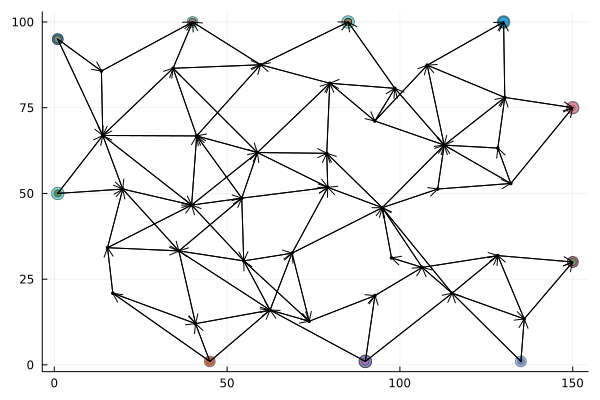

In [1]:
include("NetworkGenerator.jl")
println("Network has $(dat.n) nodes and $(dat.m) arcs with $(dat.k) commodities.")
plotNetwork(dat)

## Mathematical formulation as a Mixed Integer Linear Program

* Network $(N,A)$ of nodes & potential arcs ($\delta^\pm(i)$ the set of nodes for outgoing/incoming arcs)
* Arcs have a flow cost $c_{ij}$ and fixed cost $f_{ij}$ for building the arc, capacity $C_{ij}$
* Commodities $k\in K$ with origin/destination $(o_k,d_k)$ and flow demand $W^k$
* Variables $x^k_{ij}=$ flow of commodity $k$ on arc $(i,j)\in A$ and binary $y_{ij}=1$ if arc $(i,j)$ is built.

\begin{align*}
\min&&\sum_k \sum_{(i,j)\in A} W^k c_{ij} x^k_{ij} &+ \sum_{(i,j)\in A} f_{ij} y_{ij}\\
\text{s.t.}&&\sum_{j\in \delta^+(i)} x^k_{ij} - \sum_{j\in \delta^-(i)} x^k_{ji} &=\begin{cases}1 &\text{if }i=o_k\\-1 &\text{if }i=d_k\\0&\text{otherwise}\end{cases}&\quad&\forall\ i\in N,\ k\in K\\
&&\sum_{k\in K} W^k x^k_{ij}&\le C_{ij} y_{ij} &&\forall\ (i,j)\in A\\
&&                  x^k_{ij}&\le y_{ij}        &&\forall\ (i,j)\in A,\ k\in K\\
&& x^k_{ij}\ge 0,\ \ y_{ij}&\in\{0,1\}&&\forall\ (i,j)\in A,\ k\in K
\end{align*}

Notes:

* First set of constraints are network flow constraints that give a shortest-path problem for each commodity (if the other constraints are ignored)
* Could combined commodities to have a set of single-origin multiple-destination flows (or multiple-origin, single-destination flows). This gives a more compact but weaker formulation 
* Constraints $x^k_{ij}\le y_{ij}$ are purely included as strengthening constraints. They are not required for correctness due as the capacity constraints already imply $x^k_{ij}=0$ whenever $y_{ij}=0$
* Problem decouples for fixed $y$ as long as the capacity constraints are not binding


## Brute-force solution
This problem is small enough that the whole problem can be solved easily (though doesn't necessecarily scale well to large instances).

For now we are only interested in the LP relaxation

In [20]:
using JuMP, Gurobi # or any other solver
const GRB_ENV=Gurobi.Env(output_flag=0); # surpress startup messages
Optimizer()=Gurobi.Optimizer(GRB_ENV);
#Optimizer()=CPLEX.Optimizer();

LP relaxation bound = 11979.110814601207


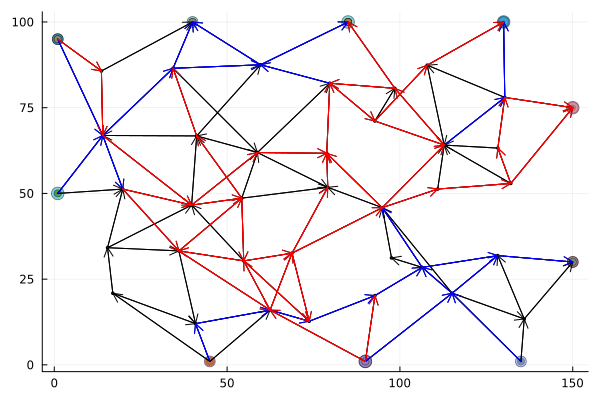

In [21]:
function solveFullProblem(P::Data;LPrelax=true, silent=true)
    N=1:P.n; A=1:P.m; K=1:P.k
    mip=Model(Optimizer);  if silent; set_silent(mip); end
    @variable(mip, x[a=A,k=K]>=0)
    if LPrelax; @variable(mip, 0 <= y[a=A] <= 1);
    else;       @variable(mip, y[a=A], Bin); end
    @objective(mip, Min, sum( P.vcost[a]*sum(P.W[k]*x[a,k] for k=K) + P.fcost[a]*y[a] for a=A))
    @constraint(mip,flow[i=N,k=K],  sum(x[e,k] for e=P.outE[i]) - sum(x[e,k] for e=P.inE[i])
                                     == ( (i==P.org[k]) ? 1 : (i==P.dst[k] ? -1 : 0) ) )
    @constraint(mip,cap[a=A], sum(P.W[k]*x[a,k] for k=K) ≤ P.cap[a] * y[a] )
    @constraint(mip,fix[a=A,k=K], x[a,k] ≤ y[a])
    optimize!(mip)
    return objective_value(mip),value.(y) # objective and edges fixed
end
LPrelaxObj,y=solveFullProblem(dat)
println("LP relaxation bound = ",LPrelaxObj)
Arc(dat,i) = (dat.frm[i],dat.to[i])
plotFracNetwork(dat,y) = plotNetwork(
    dat, [ Arc(dat,i) for i=1:dat.m if y[i]>0.99]=>:blue, 
     [ Arc(dat,i) for i=1:dat.m if 0.01 ≤ y[i] ≤ 0.99]=>:red)
plotFracNetwork(dat,y)

## Master & Subproblem

* **Master Problem** Select arcs to include in the network ($y_{ij}$ variables)
* **Subproblem**  Evaluate a network design using a linear program to route commodities ($x^k_{ij}$ variables)

### Questions
* Is this **black-box optimisation**?
* What information is the subproblem providing back to the master?

## Basic Benders Decomposition
Split into a master problem with $y$ variables and subproblem with $x$ variables

\begin{align*}
&&\min_{y,z}\sum_{(i,j)\in A} f_{ij} y_{ij}&+z\\
\text{s.t.}&&v_0+\sum_{(i,j)\in A} v_{ij} y_{ij}&\le z &\ & \forall\ v_0,\boldsymbol v=\text{optimality cut}\\
&& v_0 + \sum_{(i,j)\in A} v_{ij} y_{ij} & \le 0 && \forall\ v_0,\boldsymbol v=\text{feasibility cut}\\
&&y_{ij}&\in\{0,1\}&&\forall\ (i,j)\in A\\
z=&&\min_x \sum_k \sum_{(i,j)\in A} W^k c_{ij} x^k_{ij}\\
&&\sum_{j\in \delta^+(i)} x^k_{ij} - \sum_{j\in \delta^-(i)} x^k_{ji} &=\begin{cases}1 &\text{if }i=o_k\\-1 &\text{if }i=d_k\\0&\text{otherwise}\end{cases}&\quad&\forall\ i\in N,\ k\in K &&\text{dual: }\pi^k_i\\
&&\sum_{k\in K} W^k x^k_{ij}&\le C_{ij} y_{ij} &&\forall\ (i,j)\in A &&\text{dual: }\lambda_{ij}\\
&&                  x^k_{ij}&\le y_{ij}        &&\forall\ (i,j)\in A,\ k\in K &&\text{dual: }\mu^k_{ij}\\
&& x^k_{ij}&\ge 0&&\forall\ (i,j)\in A,\ k\in K
\end{align*}


Formulate subproblem as a dual problem. Note to get $\lambda$ & $\mu$ variables to be positive, we are treating the inequality constraints as $\ge$ constraints (i.e. $-x^k_{ij}\ge -y_{ij}$ and similarly for the $C_{ij}y_{ij}$ constraints).

\begin{align*}
z=\max&&\sum_{k\in K} (\pi^k_{o_{k}} - \pi^k_{d_k}) -\sum_{(i,j)\in A} y_{ij} &\left(C_{ij}\lambda_{ij}+\sum_{k\in K}\mu^k_{ij}\right)&&\\
\text{s.t.}&&\pi^k_i - \pi^k_j - W^k \lambda_{ij} - \mu^k_{ij} &\le W^k c_{ij} &&\forall\ (i,j)\in A,\ k\in K\\
&& \lambda_{ij}, \mu^k_{ij}&\ge 0&&\forall\ (i,j)\in A,\ k\in K
\end{align*}

* The dual problem is always _feasible:_ setting all the variables to zero is a feasible solution (assuming $W^k c_{ij}\ge 0$)
* Any dual feasible solution remains feasible no matter how the $y$ are changed.
* For $y_{ij}>0$ we get a negative cost for each of the $\lambda_{ij}$ and $\mu^k_{ij}$ so we want to make these as small as possible.

#### Optimality Cuts
Since any dual feasible solution provides a lower bound on the objective have optimality cuts:
$$z\ge \left(\sum_{k\in K} \pi^k_{o_{k}} - \pi^k_{d_k}\right) - \sum_{(i,j)\in A} \left(C_{ij}\lambda_{ij}+\sum_{k\in K}\mu^k_{ij}\right)\, y_{ij}$$
Where the coefficients $v_0$ and $-v_{ij}$ are as shown in the brackets and the dual variables are the optimal (or any feasible) solution to the dual problem.

#### Feasibility Cuts
Alternatively we may have the dual problem unbounded for a given vector $\boldsymbol y$ so if we have an infinite ray this must have a negative cost. That is we require
$$\left(\sum_{k\in K} \pi^k_{o_{k}} - \pi^k_{d_k}\right) - \sum_{(i,j)\in A} \left(C_{ij}\lambda_{ij}+\sum_{k\in K}\mu^k_{ij}\right)\, y_{ij}\le 0$$
Where the dual variables are an infinite ray.

### Generating feasibility cuts
Solvers will automatically give us an infinite ray when the problem is unbounded - or it can be found by solving an LP:

***Farka's Lemma*** *Exactly one the following sets is non-empty:*
 $$F=\{x\in \mathbb R^n : Ax=b,\ x\ge 0\} \text{ or } D=\{\pi\in\mathbb R^m : A^T \pi \le 0,\ b^T \pi=1\}$$

\begin{align*}
&&\max 0\\
\text{s.t.}&&\sum_{k\in K} (\pi^k_{o_{k}} - \pi^k_{d_k}) -\sum_{(i,j)\in A} y_{ij} \left(C_{ij}\lambda_{ij}+\sum_{k\in K}\mu^k_{ij}\right)&=1 &&\\
&&\pi^k_i - \pi^k_j - W^k \lambda_{ij} - \mu^k_{ij} &\le 0 &&\forall\ (i,j)\in A,\ k\in K\\
&& \lambda_{ij}, \mu^k_{ij}&\ge 0&&\forall\ (i,j)\in A,\ k\in K
\end{align*}

* Same as optimality problem but with zero right hand size and objective moved into constraint

Note: in principle we should never need to do this. However, when the solver detects unboundedness of the subproblem during preprocessing, or in the rare case where both primal and dual problems are infeasible, this might not happen. So either need to turn off all pre-processing and force the solver to always run a simplex algorithm to give us an unbounded ray, or solve the above problem explicitly if required, as done in the code below.

## Benders Algorithm for LP
1. Solve Master problem (with initially empty set of cuts) to get $y^*$, $z^*$ 
2. Solve (dual) subproblem for $y^*$
3. **If** dual subproblem has objective value $=z^*$ **then STOP**: the master problem is optimal
4. Generate a feasibility cut (unbounded subproblem) or optimality cut
5. Return to Step 1

Note on implementation: we return a list of cut objects that contain the coefficients of the cut and a flag to show if the cut is an optimality cut. At this point only a single cut is returned but will explore a multi-cut variant later.

In [23]:
# basic benders LP
struct Cut; opt::Bool; v::Vector{Float64}; v0::Float64; end
violation(C::Cut,y,z=0.0)=C.v0+sum(C.v[i]*y[i] for i=1:length(C.v)) - (C.opt ? z : 0)

function basicCutSep(P::Data, y::Vector{Float64})
    LP = Model(Optimizer);  set_silent(LP)
    @variable(LP,π[i=1:P.n,k=1:P.k])
    @variable(LP,λ[i=1:P.m]>=0);  @variable(LP,μ[i=1:P.m,k=1:P.k]>=0)    
    @objective(LP,Max, sum(π[P.org[k],k] - π[P.dst[k],k] for k=1:P.k) 
                     - sum(y[i] * (P.cap[i] * λ[i] + sum(μ[i,:])) for i=1:P.m))
    @constraint(LP,C[i=1:P.m, k=1:P.k], 
        π[P.frm[i],k] - π[P.to[i],k] - P.W[k]*λ[i] - μ[i,k] ≤ P.W[k]*P.vcost[i] )
    optimize!(LP)
    optcut = (termination_status(LP) == MOI.OPTIMAL)
    if ! optcut   # find Farkas' infeasibility certificate explicitly
        @objective(LP, Max, 0)            
        for i=1:P.m, k=1:P.k; set_normalized_rhs(C[i,k], 0.0); end
        @constraint(LP, sum(π[P.org[k],k] - π[P.dst[k],k] for k=1:P.k) 
                      - sum(y[i] * (P.cap[i] * λ[i] + sum(μ[i,:])) for i=1:P.m) == 1)
        optimize!(LP)
    end
    @assert(termination_status(LP) == MOI.OPTIMAL) # optimal or feasible for modified LP
    return [Cut(optcut,
        [-P.cap[i]*value(λ[i]) - sum(value(μ[i,k]) for k=1:P.k) for i=1:P.m], # vector v
        sum(value(π[P.org[k],k]) - value(π[P.dst[k],k]) for k=1:P.k))] # constant part
end;

### 1st attempt to solve the LP relaxation with Benders
Here we just try a few iterations to see what happens

Completed 10 iterations with lower bound 553.0 compared to LP 11979.110814601207


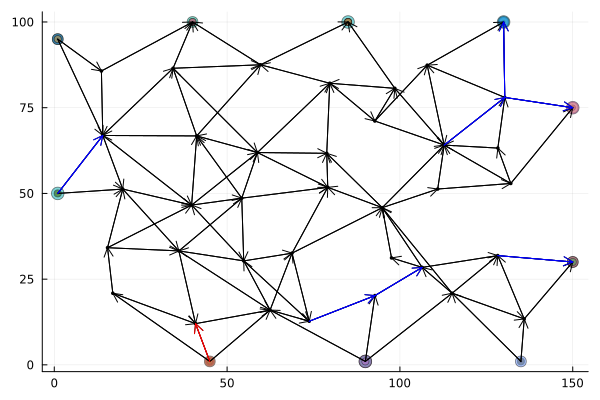

In [24]:
function benders(P::Data,cutsep;maxIter=100)
    master=Model(Optimizer);  set_silent(master)
    @variable(master, 0 <= y[i=1:P.m] <= 1);  @variable(master, z>=0)
    @objective( master,  Min,               z + sum( P.fcost[i] * y[i] for i=1:P.m))
    for iter=1:maxIter
        optimize!(master)
        cuts = cutsep(P,value.(y))
        viol = [ C for C=cuts if  violation(C, value.(y), value(z)) > 1e-4]
        if isempty(viol); break; end # EXIT
        for C in viol
            @constraint(master, C.v0 + sum(C.v[i]*y[i] for i=1:P.m) 
                <= (C.opt ? z : 0) )
        end
    end
    optimize!(master)
    return objective_value(master), value.(y)
end;
obj,y = benders(dat, basicCutSep,maxIter=10)
println("Completed 10 iterations with lower bound ",obj," compared to LP ",LPrelaxObj)
plotFracNetwork(dat,y)

### Question
* Why so few fractional arcs? 
* How do we find a better starting point?

Completed 10 iterations with lower bound 763.6449106449106 compared to LP 11979.110814601207


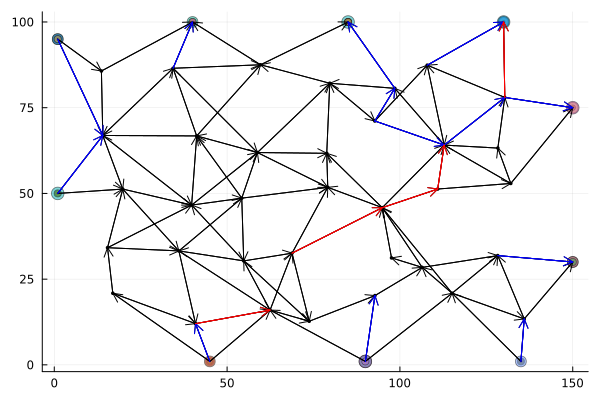

In [25]:
function benders(P::Data,cutsep;maxIter=100)
    master=Model(Optimizer);  set_silent(master)
    @variable(master, 0 <= y[i=1:P.m] <= 1);  @variable(master, z>=0)
    @objective( master,  Min,               z + sum( P.fcost[i] * y[i] for i=1:P.m))
    @constraint(master, outE[i=Set(P.org)], sum( y[e] for e=P.outE[i]) ≥ 1)
    @constraint(master, inE[i=Set(P.dst)],  sum( y[e] for e=P.inE[i])  ≥ 1)    
    bnd=Float64[]; cpu=Float64[]; isopt=Bool[]; start=time()
    for iter=1:maxIter
        optimize!(master)
        push!(bnd,objective_value(master)); push!(cpu, time()-start)
        if iter==maxIter; break; end # no point adding more cuts, just exit
        cuts = cutsep(P,value.(y))
        viol = [ C for C=cuts if  violation(C, value.(y), value(z)) > 1e-4]
        if isempty(viol); break; end # EXIT
        push!(isopt,viol[1].opt)
        for C in viol
            @constraint(master, C.v0 + sum(C.v[i]*y[i] for i=1:P.m) 
                <= (C.opt ? z : 0) )
        end
    end
    return bnd,cpu,isopt,value.(y)
end;
bnd,cpu,isopt,y = benders(dat, basicCutSep,maxIter=10)
println("Completed 10 iterations with lower bound ",bnd[end]," compared to LP ",LPrelaxObj)
plotFracNetwork(dat,y)

#### What happens if we do lots of iterations?

Completed 250 iterations (0 optimality) with LB = 3324.6514973703233 compared to LP 11979.110814601207


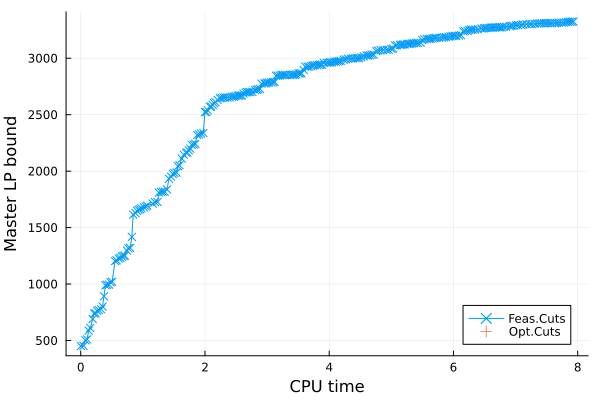

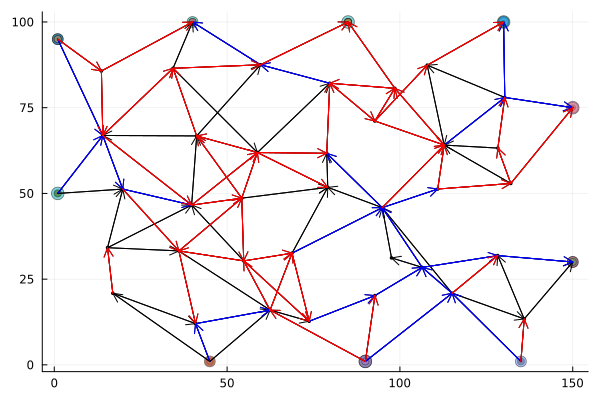

In [34]:
using Plots; default(fmt="png",legend=:bottomright)
bnd,cpu,isopt,y=benders(dat,basicCutSep,maxIter=250)
println("Completed $(length(bnd)) iterations (",count(isopt)," optimality)",
        " with LB = ",bnd[end]," compared to LP ",LPrelaxObj)
plot(cpu,bnd,marker=:x,ylabel="Master LP bound",xlabel="CPU time",label="Feas.Cuts"); opt=findall(isopt)
display(scatter!(cpu[opt],bnd[opt],marker=:plus,markersize=6,label="Opt.Cuts"))
plotFracNetwork(dat,y)

## Improving feasibility cuts
How to get feasibility sooner?

* Need to force connectivity across the network: Why not look for cuts across the network:
  *  Split set of nodes into 2 parts with at least one origin on one side & one destination on the other
  *  Must have at least one arc across each such cut
  *  Too hard to generate all of these up-front but can add violated cuts on the fly
  *  Can potentially produce multiple cuts for different origin/destinations in each iteration
* Can also arrive at this same idea in terms of the LP & Benders:
  * If the subproblem is infeasible even with just a subset of the constraints, then the overall problem is infeasible
  * For example, can drop capacity constraints
  * Now problem decomposes into $K$ feasibility (connectivity) tests between all $(o_k,d_k)$ pairs

Can be solved very quickly using a max-flow (min-cut) algorithm or just using the general LP approach.

In [28]:
function maxFlowCuts(P::Data, y::Vector{Float64})
    if sum(y) > P.n; return Cut[]; end # only try if there are few arcs so far
    LP = Model(Optimizer);  set_silent(LP)
    
    @variable(LP,π[i=1:P.n])     # could drop bounds but will always be in zero-one anyway
    @variable(LP,μ[i=1:P.m] ≥ 0) # dual of flow bound x[e,k] <= y[e]
    @objective( LP, Min,          sum(y[i] * μ[i] for i=1:P.m)) # minimise cut
    @constraint(LP, arc[i=1:P.m], π[P.frm[i]] - π[P.to[i]] ≤ μ[i])
    cuts = Cut[]
    viol = Float64[];  tried = [false for i=1:P.k]
    for k=1:P.k
        if tried[k]; continue; end # already tried this one
        fix(π[P.org[k]],1);  fix(π[P.dst[k]],0)
        optimize!(LP)
        @assert(termination_status(LP) == MOI.OPTIMAL)
        if objective_value(LP) < 1 - 1e-4
            push!(viol, 1.0-objective_value(LP))
            push!(cuts, Cut(false, # always a feasibility cut
                    [ -max(0.0, value(π[P.frm[i]]) - value(π[P.to[i]])) for i=1:P.m],
                    1.0))  # 1 - sum(y vars across cut ) <= 0
        end
        for j=k+1:P.k; 
            if abs(value(π[P.org[j]])-1) < 1e-4 && value(π[P.dst[j]]) < 1e-4
                tried[j] = true; # no need to solve this, as it would generate the same cut
        end; end
        unfix(π[P.org[k]]);  unfix(π[P.dst[k]])
    end
    #println("Found $(length(cuts)) cuts ",isempty(cuts) ? "" : "with violations $(minimum(viol)) -- $(maximum(viol))")
    return cuts
end;


Completed 250 iterations (1 optimality) with final bound 3858.9588129294243


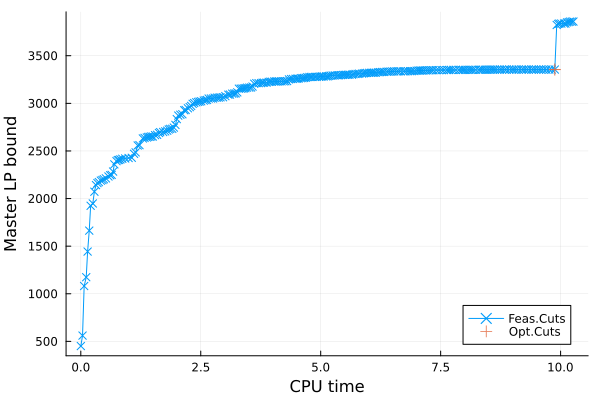

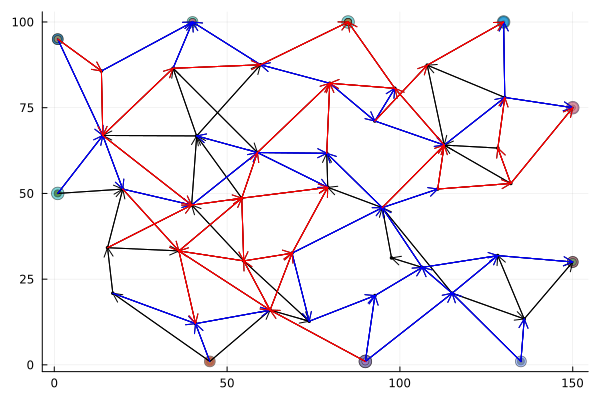

In [35]:
bnd,cpu,isopt,y=benders(dat,(P,y) -> append!(basicCutSep(P,y),maxFlowCuts(P,y)), maxIter=250)
println("Completed $(length(bnd)) iterations (",count(isopt)," optimality)",
        " with LB = ",bnd[end]," compared to LP ",LPrelaxObj)
plot(cpu,bnd,marker=:x,ylabel="Master LP bound",xlabel="CPU time",label="Feas.Cuts"); opt=findall(isopt)
display(scatter!(cpu[opt],bnd[opt],marker=:plus,markersize=6,label="Opt.Cuts"))
plotFracNetwork(dat,y)

## Magnanti-Wong accelaration - Pareto Optimal Cuts
Some cuts cut better than others.

The original idea is quite old but has been modified/improved in various ways in recent years.

> Magnanti, T. L., & Wong, R. T. (1981). [Accelerating Benders decomposition: Algorithmic enhancement and model selection criteria](https://www.jstor.org/stable/pdf/170108.pdf). Operations research, 29(3), 464-484.

> Papadakos, N. (2008). [Practical enhancements to the Magnanti–Wong method](https://www.sciencedirect.com/science/article/pii/S0167637708000102). Operations Research Letters, 36(4), 444-449.

> Sherali, H. D., & Lunday, B. J. (2013). [On generating maximal nondominated Benders cuts](https://link.springer.com/content/pdf/10.1007/s10479-011-0883-6.pdf). Annals of Operations Research, 210(1), 57-72.

   



Consider the set of cuts corresponding to $(v_0,v)\in\mathcal C$ (optimality $v_0 + v^T y\le z$ and/or feasibility cuts $v_0 + v^T y\le 0$) and let $F$ be the set of feasible solutions to the master problem excluding any cuts.

***Definition*** A cut $(v_0,v)\in\mathcal C$ **dominates** a cut $(w_0,w)\in\mathcal C$ if 
$$\forall y\in F,\ v_0 +v^T y \ge w_0 + w^T y\quad\text{ and }\quad\exists y\in F: v_0 +v^T y > w_0 + w^T y$$

***Definition*** A cut is **Pareto-optimal** if it is not dominated by any other cut.


Question: Subproblem gives a single solution, why might this not be Pareto-optimal? How to find a Pareto-optimal cut?

Answer: 
* The (dual) subproblem can be (and often is) degenerate so that there are many optimal solutions - the solver just returns the first optimal solution it finds
* To find a Pareto-optimal solution may want to choose a "better" solution from the set of all Pareto-optimal ones



### Magnanti-Wong approach:
1. Pick a **core point** $\hat y$ in the *relative interior of the convex hull of feasible solutions to the master*. In the simple case where we simply require $y\in \{0,1\}^m$ for the master problem (without further constraints), this just means picking $y\in (0,1)^m$
2. For a given solution $\bar y$ of the master, solve the basic dual problem  
   $$\max f(\bar y)^T \nu \text{ s.t. } A^T\nu \le \bar c$$
   * Here $\nu=(\pi,\lambda,\mu)$ and $f(\bar y)$ gives the cost coefficients as a function of $\bar y$
   * $A^T$ is short hand for the constraint matrix ($[A^T \nu]_{ijk} = \pi^k_i - \pi^k_j - W^k \lambda_{ij} - \mu^k_{ij}$)
   * $\bar c$ is the right hand side of the problem $W^kc_{ij}$
   Let $z^*$ be the optimal objective value for this problem
3. Now solve a second problem to pick amongs the optimal solutions
   $$\max f(\hat y) \nu \text{ s.t. } A^T\nu \le \bar c\text { and } f(\bar y)\nu = z^*$$

### Variations on this theme
There are two issues to consider 

1. How to choose the core point $\hat y$?
2. How to minimise the computational cost of solving the dual LP again with an additional constraint?

Regarding core points:

* A "good" core point can significantly improve things but there is no consensus of a general way to choose the core point
* One generic approach: use an interior point solver _without cross-over_ and select the optimal interior point as core point. Barrier/interior-point methods tend to be quite fast with the cross-over time typically dominating solution time.
* There is a larger set of "Magnanti-Wong" points (possible values $\hat y$) that produce Pareto-optimal cuts than just core points
* For any M-W point $\hat y$ and master probelm solution $\bar y$, any convex combination of $\hat y$ and $\bar y$ is a M-W point

Paper considers 3 options:

1. Start with $\hat y_{ij}=1\ \forall\ (i,j)\in A$ and update $\hat y\leftarrow  (\hat y + \bar y)/2$ where $\bar y$ is the optimal solution to the master in the current iteration
2. As for 1 but only update using incumbent solutions
3. Fix as $\hat y_{ij} = 0.7$ if $(i,j)$ is part of the shortest path between $o_k$ and $d_k$ for some $k$ and $\hat y_{ij}=0.2$ otherwise

The third method seemed to work best but the first was not much worse.

For the feasibility cuts we follow the approach suggested by Fischetti et al in [A note on the selection of Benders Cuts](https://link.springer.com/article/10.1007/s10107-010-0365-7) who show that the role of objective & constraint can be swaped for the second iteration of feasibility cut generation and that this tends to perform better in practice.

In [30]:
function mwCutSep(P::Data, y::Vector{Float64}, mw::Vector{Float64}) # updates the mw vector
    LP = Model(Optimizer);  set_silent(LP)
    @variable(LP,π[i=1:P.n,k=1:P.k],)
    @variable(LP,λ[i=1:P.m]>=0);  @variable(LP,μ[i=1:P.m,k=1:P.k]>=0)
    
    @objective(LP,Max, sum(π[P.org[k],k] - π[P.dst[k],k] for k=1:P.k) 
                     - sum(y[i] * (P.cap[i] * λ[i] + sum(μ[i,:])) for i=1:P.m))
    @constraint(LP,C[i=1:P.m, k=1:P.k], π[P.frm[i],k] - π[P.to[i],k] - P.W[k]*λ[i] - μ[i,k] ≤ P.W[k]*P.vcost[i] )
    optimize!(LP)
    optcut = (termination_status(LP) == MOI.OPTIMAL)
    
    cuts = []
    if optcut
        cuts = [Cut(optcut,
            [-P.cap[i]*value(λ[i]) - sum(value(μ[i,k]) for k=1:P.k) for i=1:P.m], # vector v
            sum(value(π[P.org[k],k]) - value(π[P.dst[k],k]) for k=1:P.k))]
        obj = objective_value(LP)
        @constraint(LP, obj - 1e-7 <= sum(π[P.org[k],k] - π[P.dst[k],k] for k=1:P.k) 
                      - sum(y[i] * (P.cap[i] * λ[i] + sum(μ[i,:])) for i=1:P.m) <= obj+1e-7)
    else # find Farkas' infeasibility certificate 
        for i=1:P.m, k=1:P.k; set_normalized_rhs(C[i,k], 0.0); end
        @constraint(LP, sum(π[P.org[k],k] - π[P.dst[k],k] for k=1:P.k) 
                      - sum(y[i] * (P.cap[i] * λ[i] + sum(μ[i,:])) for i=1:P.m) == 1)
    end
    @objective(LP, Max,  sum(π[P.org[k],k] - π[P.dst[k],k] for k=1:P.k) 
                       - sum(mw[i] * (P.cap[i] * λ[i] + sum(μ[i,:])) for i=1:P.m))
    optimize!(LP)
    if termination_status(LP) != MOI.OPTIMAL && length(cuts) >0; return cuts; end
    @assert(termination_status(LP) == MOI.OPTIMAL, # optimal solution should exist at this point 
        "Termination status $(termination_status(LP)) for optcut=$optcut") 
    return [Cut(optcut,
        [-P.cap[i]*value(λ[i]) - sum(value(μ[i,k]) for k=1:P.k) for i=1:P.m], # vector v
        sum(value(π[P.org[k],k]) - value(π[P.dst[k],k]) for k=1:P.k))] # constant part
end;

In [71]:
mwpoint=Float64[]
function mwCutSep(P::Data,y::Vector{Float64};useFlow=true)
    global mwpoint
    if length(mwpoint) != length(y)
        mwpoint = ones(length(y))
    end
    cuts = mwCutSep(P,y,mwpoint)
    if cuts[1].opt # only move towards feasible points
        mwpoint = 0.5 * mwpoint + 0.5 * y
    end
    if useFlow; append!(cuts, maxFlowCuts(P,y)); end
    return cuts
end;

Completed 250 iterations LB = 11793.664013110825 compared to LP 11979.110814601207


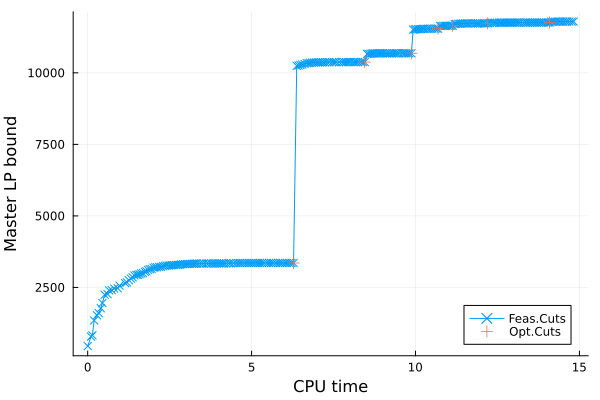

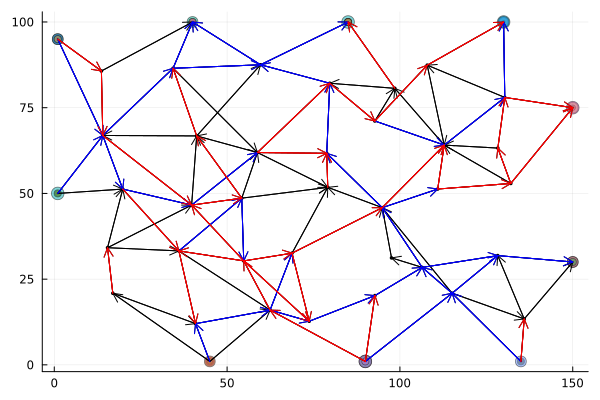

In [72]:
bnd,cpu,isopt,y=benders(dat,(P,y)->mwCutSep(P,y;useFlow=true), maxIter=250)
println("Completed $(length(bnd)) iterations LB = ",bnd[end]," compared to LP ",LPrelaxObj); flush(stdout)
plot(cpu,bnd,marker=:x,ylabel="Master LP bound",xlabel="CPU time",label="Feas.Cuts"); opt=findall(isopt)
display(scatter!(cpu[opt],bnd[opt],marker=:plus,markersize=6,label="Opt.Cuts"))
plotFracNetwork(dat,y)

## Integer Solutions - Classic Benders
Same as before but now we solve the master problem to **integer optimality**. That is $y\in\mathbb Z_2^m$

In [43]:
function classicBenders(P::Data,cutsep;maxIter=100)
    master=Model(Optimizer);  set_silent(master)
    @variable(master, y[i=1:P.m], Bin);  @variable(master, z>=0)
    @objective( master,  Min,               z + sum( P.fcost[i] * y[i] for i=1:P.m))
    @constraint(master, outE[i=Set(P.org)], sum( y[e] for e=P.outE[i]) ≥ 1)
    @constraint(master, inE[i=Set(P.dst)],  sum( y[e] for e=P.inE[i])  ≥ 1)    
    bnd=Float64[]; cpu=Float64[]; isopt=Bool[]; start=time()
    for iter=1:maxIter
        optimize!(master)
        push!(bnd,objective_value(master)); push!(cpu, time()-start)
        if iter == maxIter; break; end
        cuts = cutsep(P,value.(y))
        viol = [ C for C=cuts if  violation(C, value.(y), value(z)) > 1e-4]
        if isempty(viol); break; end # EXIT
        push!(isopt,viol[1].opt)
        for C in viol
            @constraint(master, C.v0 + sum(C.v[i]*y[i] for i=1:P.m) <= (C.opt ? z : 0) )
        end
    end
    return bnd,cpu,isopt,value.(y)
end;

Completed in 150 iterations (1 optimality) with final bound 9692.000004700036


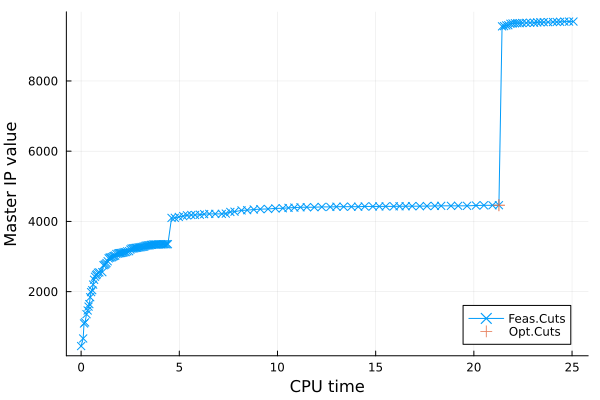

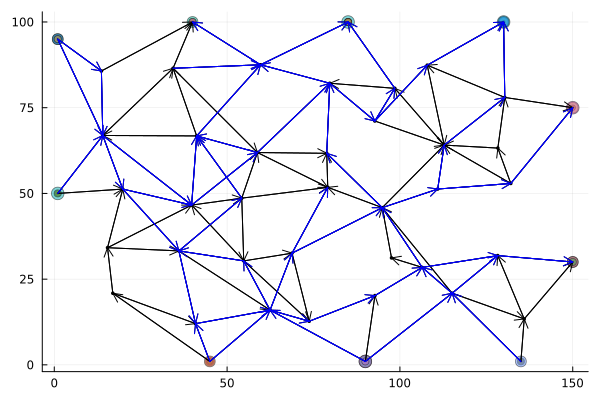

In [73]:
bnd,cpu,isopt,y=classicBenders(dat,mwCutSep,maxIter=150)
println("Completed in $(length(bnd)) iterations (",count(isopt)," optimality)",
        " with final bound ",bnd[end])
plot(cpu,bnd,marker=:x,ylabel="Master IP value",xlabel="CPU time",label="Feas.Cuts"); opt=findall(isopt)
display(scatter!(cpu[opt],bnd[opt],marker=:plus,markersize=6,label="Opt.Cuts"))
plotFracNetwork(dat,y)

***Note:*** There are some long delays finding integer solutions that are cut off as infeasible anyway. Better to just solve the LP first:

In [45]:
function classicBenders(P::Data,cutsep;maxIter=100)
    master=Model(SOLVER.Optimizer);  set_silent(master)
    @variable(master, 0 <= y[i=1:P.m] <= 1);  @variable(master, z>=0)
    @objective( master,  Min,               z + sum( P.fcost[i] * y[i] for i=1:P.m))
    @constraint(master, outE[i=Set(P.org)], sum( y[e] for e=P.outE[i]) ≥ 1)
    @constraint(master, inE[i=Set(P.dst)],  sum( y[e] for e=P.inE[i])  ≥ 1)    
    bnd=Float64[]; cpu=Float64[]; isopt=Bool[]; start=time(); isBinary=false
    for iter=1:maxIter
        optimize!(master)
        push!(bnd,objective_value(master)); push!(cpu, time()-start)
        if iter == maxIter; break; end
        cuts = cutsep(P,value.(y))
        viol = [ C for C=cuts if  violation(C, value.(y), value(z)) > 1e-4]
        if isempty(viol) && isBinary;  break; end
        if iter == maxIter ÷ 2 || isempty(viol) # switch to binary
            isBinary=true; 
            for i=1:P.m; set_binary(y[i]); end
            if isempty(viol); continue; end
        end
        push!(isopt,viol[1].opt)
        for C in viol
            @constraint(master, C.v0 + sum(C.v[i]*y[i] for i=1:P.m) <= (C.opt ? z : 0) )
        end
    end
    return bnd,cpu,isopt,value.(y)
end;

 61.016245 seconds (42.00 M allocations: 2.561 GiB, 1.31% gc time)
Completed 267 iterations (24 optimality) with final bound 12928.9999999 compared to LP 11979.110814601207


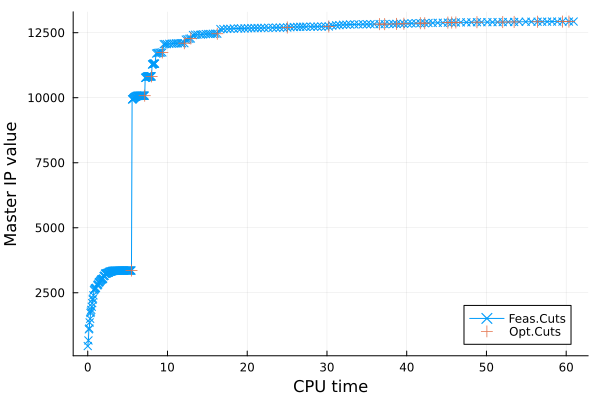

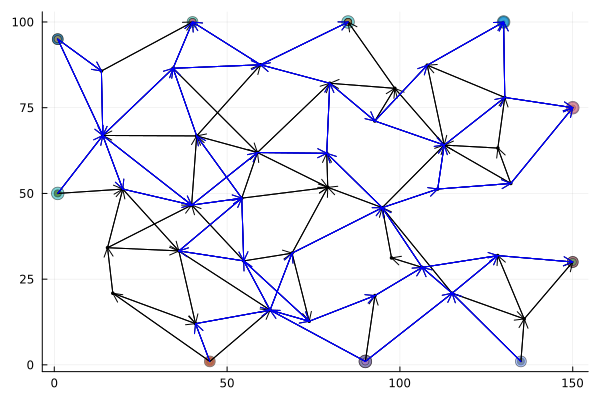

In [74]:
@time bnd,cpu,isopt,y=classicBenders(dat,mwCutSep,maxIter=300)
println("Completed $(length(bnd)) iterations (",count(isopt)," optimality)",
        " with final bound ",bnd[end], " compared to LP ",LPrelaxObj)
plot(cpu,bnd,marker=:x,ylabel="Master IP value",xlabel="CPU time",label="Feas.Cuts"); opt=findall(isopt)
display(scatter!(cpu[opt],bnd[opt],marker=:plus,markersize=6,label="Opt.Cuts"))
plotFracNetwork(dat,y)

## Modern Benders

Here we add cuts via a callback. Key functions (all contained in the `MOI` module = MathOptInterface):

* `UserCut(cbdata)` just indicates that this constraint is a cut to eliminate a fractional solution
* `LazyConstraint(cbdata)` a constraint necessary for correctness: it eliminates an integer solution
* `set_attribute(MIP,MOI.UserCutCallback(), cbdata -> f(cbdata)`: tell the solver for the given MIP
  to use the given function to check for user generated fractional cuts (i.e. the function should be 
  called during the branch-and-bound whenever at a fractional node in addition to the solver's built-in
  cut generators). `MOI.LazyConstraintCallback()` is the same but allows a different function to be
  used for generating integer cuts.
* `callback_node_status(cbdata,master)`: allows checking of what the node status is so we can use the
  same function for both fractional & integer cuts.

In [75]:
mutable struct ProgressInfo 
    bnd::Vector{Float64};cpu::Vector{Float64};isopt::Vector{Bool}; start::Float64;
end
function cut_callback(cbdata,P::Data,cutsep,master,yvar,zvar,info::ProgressInfo,
        doFracCut=false) 
    isFracCut = callback_node_status(cbdata,master)  == MOI.CALLBACK_NODE_STATUS_FRACTIONAL
    if  isFracCut && ! doFracCut;  return; end
    if  doFracCut && ! isFracCut;  return; end # just generate lazy constraints at this point
    yval = [callback_value(cbdata,y) for y=yvar]
    zval = callback_value(cbdata,zvar)
    cuts = cutsep(P,yval)
    viol = [ C for C=cuts if  violation(C, yval, zval) > 1e-4]
    if isempty(viol); return; end
    push!(info.bnd,zval + sum( P.fcost[i] * yval[i] for i=1:P.m)); 
    push!(info.cpu, time()-info.start)
    push!(info.isopt, viol[1].opt)
    for C in viol 
        # here we build a constraint where the RHS is z (if C.opt==true) or 0 otherwise
        cut = @build_constraint(C.v0 + sum(C.v[i]*yvar[i] for i=1:P.m) <= (C.opt ? zvar : 0) )
        if isFracCut  # UserCut is just cutting of a fractional point to tighten the LP relaxation
            MOI.submit(master,MOI.UserCut(cbdata), cut ) # the solver may ignore this constraint
        else  # constraints for integer points must be added for model correctness.
            MOI.submit(master,MOI.LazyConstraint(cbdata), cut)
        end
    end
end;

In [76]:
function modernBenders(P::Data,cutsep;useFracCut=true)
    master=Model(Optimizer); set_silent(master)
    @variable(master, y[i=1:P.m],Bin);  
    @variable(master, z >= 0)  # objecive of sub-problem
    @objective( master,  Min,               z + sum( P.fcost[i] * y[i] for i=1:P.m))
    @constraint(master, outE[i=Set(P.org)], sum( y[e] for e=P.outE[i]) ≥ 1)
    @constraint(master, inE[i=Set(P.dst)],  sum( y[e] for e=P.inE[i])  ≥ 1)    
    progInfo = ProgressInfo([],[],[],time())
    # g = (x) -> f(x,y) creates a new function of one argument. It means g(3) calls 
    # f(3,y) where y has the value at the time g was defined.
    set_attribute(master, MOI.LazyConstraintCallback(), # pass local variables on
            (cbdata)->cut_callback(cbdata,P,cutsep,master,y,z,progInfo,false))
    if useFracCut
        set_attribute(master,MOI.UserCutCallback(),  # same function just force doFracCut=true
            (cbdata)->cut_callback(cbdata,P,cutsep,master,y,z,progInfo,true)) 
    end
    optimize!(master)
    push!(progInfo.bnd,objective_value(master))
    push!(progInfo.cpu,time()-progInfo.start)
    push!(progInfo.isopt,true)
    return progInfo.bnd,progInfo.cpu,progInfo.isopt, value.(y)
end;

 18.637951 seconds (46.38 M allocations: 2.860 GiB, 4.25% gc time, 3.00% compilation time)
Completed in 294 iterations (37 optimality) with final bound 12928.999999900012


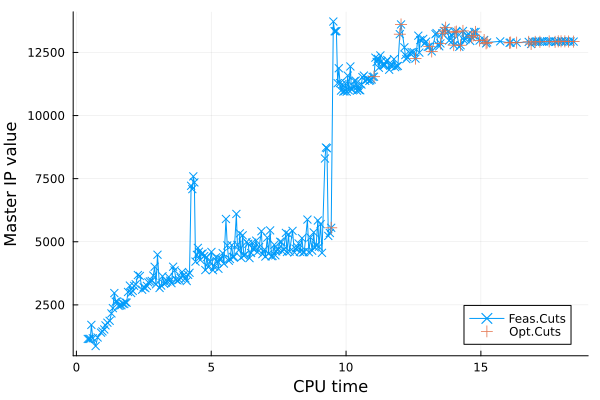

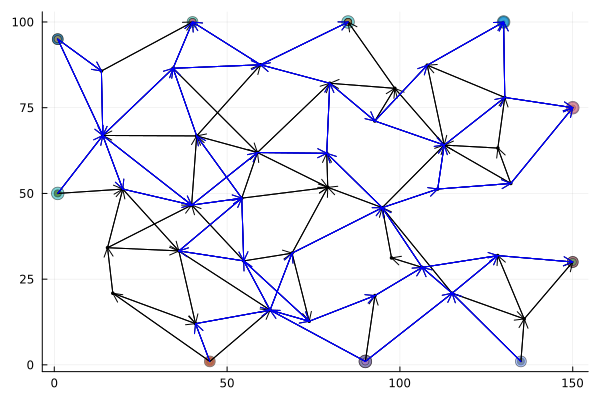

In [78]:
@time bnd,cpu,isopt,y=modernBenders(dat, mwCutSep,useFracCut=false)
println("Completed in $(length(bnd)) iterations (",count(isopt)," optimality)",
        " with final bound ",bnd[end])
plot(cpu,bnd,marker=:x,ylabel="Master IP value",xlabel="CPU time",label="Feas.Cuts"); opt=findall(isopt)
display(scatter!(cpu[opt],bnd[opt],marker=:plus,markersize=6,label="Opt.Cuts"))
plotFracNetwork(dat,y)